## imports

In [1]:
%matplotlib inline

In [2]:
import sys
import os
sys.path.append("../")
import copy

In [3]:
cur_folder_name = os.getcwd().split('/')[-1]
if cur_folder_name != "fairness-variance":
    os.chdir("../..")

print('Current location: ', os.getcwd())

Current location:  /Users/tarasbohdan/Desktop/Experiments-AAAI-24


In [4]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

from aif360.algorithms.preprocessing.lfr import LFR

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from virny.preprocessing import preprocess_dataset
from source.preprocessing import get_simple_preprocessor

from notebooks.mult_repair_levels_student_performance.StudentPerformanceDataset import StudentPerformanceDataset

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import matplotlib.pyplot as plt


pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'


## dataset loading

In [5]:
class Config:
    file_name = './data/student_performance/student-mat.csv'
    Az_EXPERIMENT_PARAMETERS_LIST = ...
    Ax_EXPERIMENT_PARAMETERS_LIST = ...
    Ay_EXPERIMENT_PARAMETERS_LIST = ...
    BINS_SIZE = 10
    Az_DEFAULT_VALUE = 50.0
    Ax_DEFAULT_VALUE = ...
    Ay_DEFAULT_VALUE = ...
    sensitive_attribute = 'sex_binary'

In [6]:
np.linspace(0, Config.Az_DEFAULT_VALUE, Config.BINS_SIZE + 1)

array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.])

In [7]:
data_loader = StudentPerformanceDataset(Config.file_name)
data_loader.X_data.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,Mjob,Fjob,reason,guardian,sex
0,18,4,4,2,2,0,4,3,4,1,1,3,6,at_home,teacher,course,mother,F
1,17,1,1,1,2,0,5,3,3,1,1,3,4,at_home,other,course,father,F
2,15,1,1,1,2,3,4,3,2,2,3,3,10,at_home,other,other,mother,F
3,15,4,2,1,3,0,3,2,2,1,1,5,2,health,services,home,mother,F
4,16,3,3,1,2,0,4,3,2,1,2,5,4,other,other,home,father,F


## dataset processing

In [8]:
init_data_loader = copy.deepcopy(data_loader)

In [9]:
data_loader.categorical_columns = [col for col in data_loader.categorical_columns if
                                   col not in ('sex')]
data_loader.X_data['sex_binary'] = data_loader.X_data['sex'].apply(lambda x: 1 if x == 'M' else 0)
data_loader.full_df = data_loader.full_df.drop(['sex'], axis=1)
data_loader.X_data = data_loader.X_data.drop(['sex'], axis=1)

column_transformer = get_simple_preprocessor(data_loader)
base_flow_dataset = preprocess_dataset(data_loader, column_transformer, 0.3, 42)
base_flow_dataset.init_features_df = init_data_loader.full_df.drop(init_data_loader.target, axis=1,
                                                                   errors='ignore')
base_flow_dataset.X_train_val['sex_binary'] = data_loader.X_data.loc[
    base_flow_dataset.X_train_val.index, 'sex_binary']
base_flow_dataset.X_test['sex_binary'] = data_loader.X_data.loc[base_flow_dataset.X_test.index, 'sex_binary']

/var/folders/cg/l243p36n10s5v1x_vrt2wzs80000gn/T/ipykernel_7982/2332353883.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_loader.X_data['sex_binary'] = data_loader.X_data['sex'].apply(lambda x: 1 if x == 'M' else 0)
/Users/tarasbohdan/Desktop/Experiments-AAAI-24/virny_venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## compute basic metrics

In [10]:
dataset_orig_train, dataset_orig_test = train_test_split(data_loader.X_data, test_size=0.3)

In [11]:
train_df = base_flow_dataset.X_train_val
train_df[base_flow_dataset.target] = base_flow_dataset.y_train_val

test_df = base_flow_dataset.X_test
test_df[base_flow_dataset.target] = base_flow_dataset.y_test

In [12]:
train_binary_dataset = BinaryLabelDataset(df=train_df,
                                              label_names=[data_loader.target],
                                              protected_attribute_names=[Config.sensitive_attribute],
                                              favorable_label=1,
                                              unfavorable_label=0)
test_binary_dataset = BinaryLabelDataset(df=test_df,
                                         label_names=[data_loader.target],
                                         protected_attribute_names=[Config.sensitive_attribute],
                                         favorable_label=1,
                                         unfavorable_label=0)

In [13]:
privileged_groups = [{'sex_binary': 1}]
unprivileged_groups = [{'sex_binary': 0}]

metric_orig_train = BinaryLabelDatasetMetric(train_binary_dataset,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())
metric_orig_test = BinaryLabelDatasetMetric(test_binary_dataset,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.034286


#### Original test dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.154042


In [14]:
TR = LFR(unprivileged_groups=unprivileged_groups,
         privileged_groups=privileged_groups,
         Az=50.0,
         verbose=1
        )
TR = TR.fit(train_binary_dataset)

step: 0, loss: 1.5789881282181042, L_x: 1.3925950920581491,  L_y: 0.6370704135887031,  L_z: 0.018559835274176394
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          160     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57899D+00    |proj g|=  5.32037D-01
step: 250, loss: 1.287582297528409, L_x: 1.4026794146399286,  L_y: 0.6198502094819266,  L_z: 0.013074105878001663

At iterate    1    f=  1.28758D+00    |proj g|=  5.04644D-01

At iterate    2    f=  9.63877D-01    |proj g|=  7.16003D-01
step: 500, loss: 1.7073533726762915, L_x: 1.392966691200734,  L_y: 0.6143773055314389,  L_z: 0.021580928004656906
step: 750, loss: 0.9013452462687079, L_x: 1.401967885386696,  L_y: 0.6160805494148989,  L_z: 0.005424900359998841

At iterate    3    f=  9.01345D-01    |proj g|=  5.21952D-01
step: 1000, loss: 0.8878106739105358, L_x: 1.4017234625919235,  L_y: 0.6151772887383066,  L_z: 0.0051723230109261996

At iterate  

In [15]:
dataset_transf_train = TR.transform(train_binary_dataset)
dataset_transf_test = TR.transform(test_binary_dataset)

In [16]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())
metric_transf_test = BinaryLabelDatasetMetric(dataset_transf_test,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Transformed test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_test.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


#### Transformed test dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


In [17]:
train_df, _ = train_binary_dataset.convert_to_dataframe()
test_df, _ = test_binary_dataset.convert_to_dataframe()

In [18]:
train_df.head(10)

,cat__Mjob_at_home,cat__Mjob_health,cat__Mjob_other,cat__Mjob_services,cat__Mjob_teacher,cat__Fjob_at_home,cat__Fjob_health,cat__Fjob_other,cat__Fjob_services,cat__Fjob_teacher,...,num__failures,num__famrel,num__freetime,num__goout,num__Dalc,num__Walc,num__health,num__absences,sex_binary,G3
17,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.462007,1.215287,-0.249043,-1.016419,-0.557247,-1.013096,0.322877,-0.221442,0.0,1.0
165,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.894524,0.050637,1.714836,-1.016419,-0.557247,-1.013096,-1.080495,1.159755,1.0,1.0
24,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.462007,0.050637,-0.249043,-1.016419,-0.557247,-1.013096,1.024563,-0.451641,0.0,0.0
126,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.462007,1.215287,-0.249043,-1.016419,-0.557247,-1.013096,-1.782181,-0.681841,0.0,1.0
346,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,-0.462007,1.215287,-0.249043,-1.016419,-0.557247,-0.247029,0.322877,0.354057,1.0,1.0
176,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.462007,-1.114013,0.732897,0.759098,-0.557247,1.285105,1.024563,-0.451641,0.0,1.0
275,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.462007,0.050637,0.732897,0.759098,0.565382,0.519038,1.024563,0.008758,0.0,1.0
246,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.462007,1.215287,-1.230982,-1.016419,-0.557247,-1.013096,-1.080495,-0.221442,1.0,1.0
239,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.894524,1.215287,1.714836,0.759098,1.688010,2.051172,-1.080495,-0.681841,1.0,0.0
153,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.607587,0.050637,1.714836,0.759098,-0.557247,-1.013096,0.322877,-0.681841,1.0,0.0


In [19]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42)

In [20]:
train_X = train_df.drop(['G3'], axis=1)
train_y = train_df['G3']

In [21]:
test_X = test_df.drop(['G3'], axis=1)
test_y = test_df['G3']

In [22]:
rfc = rfc.fit(train_X, train_y)

In [23]:
y_pred = rfc.predict(test_X)

In [24]:
report = classification_report(test_y, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.28      0.42        46
         1.0       0.68      0.96      0.80        73

    accuracy                           0.70       119
   macro avg       0.75      0.62      0.61       119
weighted avg       0.73      0.70      0.65       119



In [25]:
train_df, _ = dataset_transf_train.convert_to_dataframe()
test_df, _ = dataset_transf_test.convert_to_dataframe()

rfc = RandomForestClassifier(random_state=42)

train_X = train_df.drop(['G3'], axis=1)
train_y = train_df['G3']

test_X = test_df.drop(['G3'], axis=1)
test_y = test_df['G3']

rfc = rfc.fit(train_X, train_y)

y_pred = rfc.predict(test_X)

report = classification_report(test_y, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       119

    accuracy                           1.00       119
   macro avg       1.00      1.00      1.00       119
weighted avg       1.00      1.00      1.00       119



## Tune parameters for LFR

### Az parameter tuning

In [26]:
def calculate_false_negative_rate_difference(train_bin_dset, test_bindset, y_true, y_pred, params):
    test_binary_dataset_pred = test_bindset.copy()
    test_binary_dataset_pred.labels = y_pred

    metric = ClassificationMetric(
        test_bindset, test_binary_dataset_pred,
        unprivileged_groups=params["unprivileged_groups"],
        privileged_groups=params["privileged_groups"]
    )

    return metric.false_negative_rate_difference()

In [27]:
def calculate_false_positive_rate_difference(train_bin_dset, test_bindset, y_true, y_pred, params):
    test_binary_dataset_pred = test_bindset.copy()
    test_binary_dataset_pred.labels = y_pred

    metric = ClassificationMetric(
        test_bindset, test_binary_dataset_pred,
        unprivileged_groups=params["unprivileged_groups"],
        privileged_groups=params["privileged_groups"]
    )

    return metric.false_positive_rate_difference()

In [28]:
def calculate_opportunity_difference(train_bin_dset, test_bindset, y_true, y_pred, params):
    test_binary_dataset_pred = test_bindset.copy()
    test_binary_dataset_pred.labels = y_pred

    metric = ClassificationMetric(
        test_bindset, test_binary_dataset_pred,
        unprivileged_groups=params["unprivileged_groups"],
        privileged_groups=params["privileged_groups"]
    )

    return metric.equal_opportunity_difference()

In [29]:
def calculate_disparate_impact(train_bin_dset, test_bindset, y_true, y_pred, params):
    test_binary_dataset_pred = test_bindset.copy()
    test_binary_dataset_pred.labels = y_pred

    metric = ClassificationMetric(
        test_bindset, test_binary_dataset_pred,
        unprivileged_groups=params["unprivileged_groups"],
        privileged_groups=params["privileged_groups"]
    )

    return metric.disparate_impact()

In [30]:
from sklearn.metrics import jaccard_score


def calculate_stability(train_binary_dataset, test_binary_dataset, y_true, y_pred, params):
    if "average" in params:
        average = params["average"]
    else:
        average = "binary"

    return jaccard_score(y_true, y_pred, average=average)

In [31]:
from sklearn.metrics import mean_squared_error

def calculate_uncertainty(train_binary_dataset, test_binary_dataset, y_true, y_pred, params):
    return mean_squared_error(y_true, y_pred)

In [35]:
def compute_label_stability(predicted_labels: list):
    count_pos = sum(predicted_labels)
    count_neg = len(predicted_labels) - count_pos

    return np.abs(count_pos - count_neg) / len(predicted_labels)

In [36]:
def calculate_metrics(train_binary_dataset, test_binary_dataset, y_true, y_pred, params):
    metric = params["metric"]

    if metric == 'accuracy':
        return accuracy_score(y_true, y_pred)
    elif metric == 'classification_report':
        return classification_report(y_true, y_pred)
    elif metric == 'disparate_impact':
        return calculate_disparate_impact(train_binary_dataset, test_binary_dataset, y_true, y_pred, params)
    elif metric == 'equal_opportunity_difference':
        return calculate_opportunity_difference(train_binary_dataset, test_binary_dataset, y_true, y_pred, params)
    elif metric == 'false_positive_rate_difference':
        return calculate_false_positive_rate_difference(train_binary_dataset, test_binary_dataset, y_true, y_pred, params)
    elif metric == 'false_negative_rate_difference':
        return calculate_false_negative_rate_difference(train_binary_dataset, test_binary_dataset, y_true, y_pred, params)
    elif metric == 'stability':
        return calculate_stability(train_binary_dataset, test_binary_dataset, y_true, y_pred, params)
    elif metric == 'uncertainty':
        return calculate_uncertainty(train_binary_dataset, test_binary_dataset, y_true, y_pred, params)
    # elif metric == 'jitter':
    #     return compute_jitter(y_pred)
    elif metric == 'label_stability':
        return compute_label_stability(y_pred)

    raise ValueError(f"Unsupported metric: {metric}")

In [34]:
def run_experiment(az_parameters, Ax, Ay, train_binary_dataset, test_binary_dataset, params):
    metric_results = []

    for az in az_parameters:
        if az == 0:
            train_df, _ = train_binary_dataset.convert_to_dataframe()
            test_df, _ = test_binary_dataset.convert_to_dataframe()
        else:
            TR = LFR(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups,
                     Ax=Ax, Ay=Ay, Az=az)
            TR = TR.fit(train_binary_dataset)

            dataset_transf_train = TR.transform(train_binary_dataset)
            dataset_transf_test = TR.transform(test_binary_dataset)

            train_df, _ = dataset_transf_train.convert_to_dataframe()
            test_df, _ = dataset_transf_test.convert_to_dataframe()

        rfc = RandomForestClassifier(random_state=42)

        train_X = train_df.drop(['G3'], axis=1)
        train_y = train_df['G3']

        test_X = test_df.drop(['G3'], axis=1)
        test_y = test_df['G3']

        rfc = rfc.fit(train_X, train_y)

        y_pred = rfc.predict(test_X)

        metric_value = calculate_metrics(train_binary_dataset, test_binary_dataset, test_y, y_pred, params)
        metric_results.append(metric_value)

    return metric_results

In [39]:
def run_and_plot_experiment(params):

    Az_VALUES = params["Az_VALUES"]
    Ax_VALUES = params["Ax_VALUES"]
    Ay_VALUES = params["Ay_VALUES"]
    metric = params["metric"]

    param_combinations = list(product(Ax_VALUES, Ay_VALUES))

    fig, axes = plt.subplots(len(Ax_VALUES), len(Ay_VALUES), figsize=(16, 12))
    fig.suptitle(f"{metric} vs. Az & Ax & Ay")

    for i, values in enumerate(param_combinations):
        Ax, Ay = values[0], values[1]

        metric_values = run_experiment(Az_VALUES, Ax, Ay, train_binary_dataset, test_binary_dataset, params)

        row_index = i // len(Ay_VALUES)
        col_index = i % len(Ay_VALUES)

        ax = axes[row_index, col_index]
        ax.plot(Az_VALUES, metric_values, marker='o', label=f'Ax={Ax}, Ay={Ay}')
        ax.set_title(f"Ax={Ax}, Ay={Ay}")
        ax.set_xlabel("Az Parameter")
        ax.set_ylabel(metric)
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

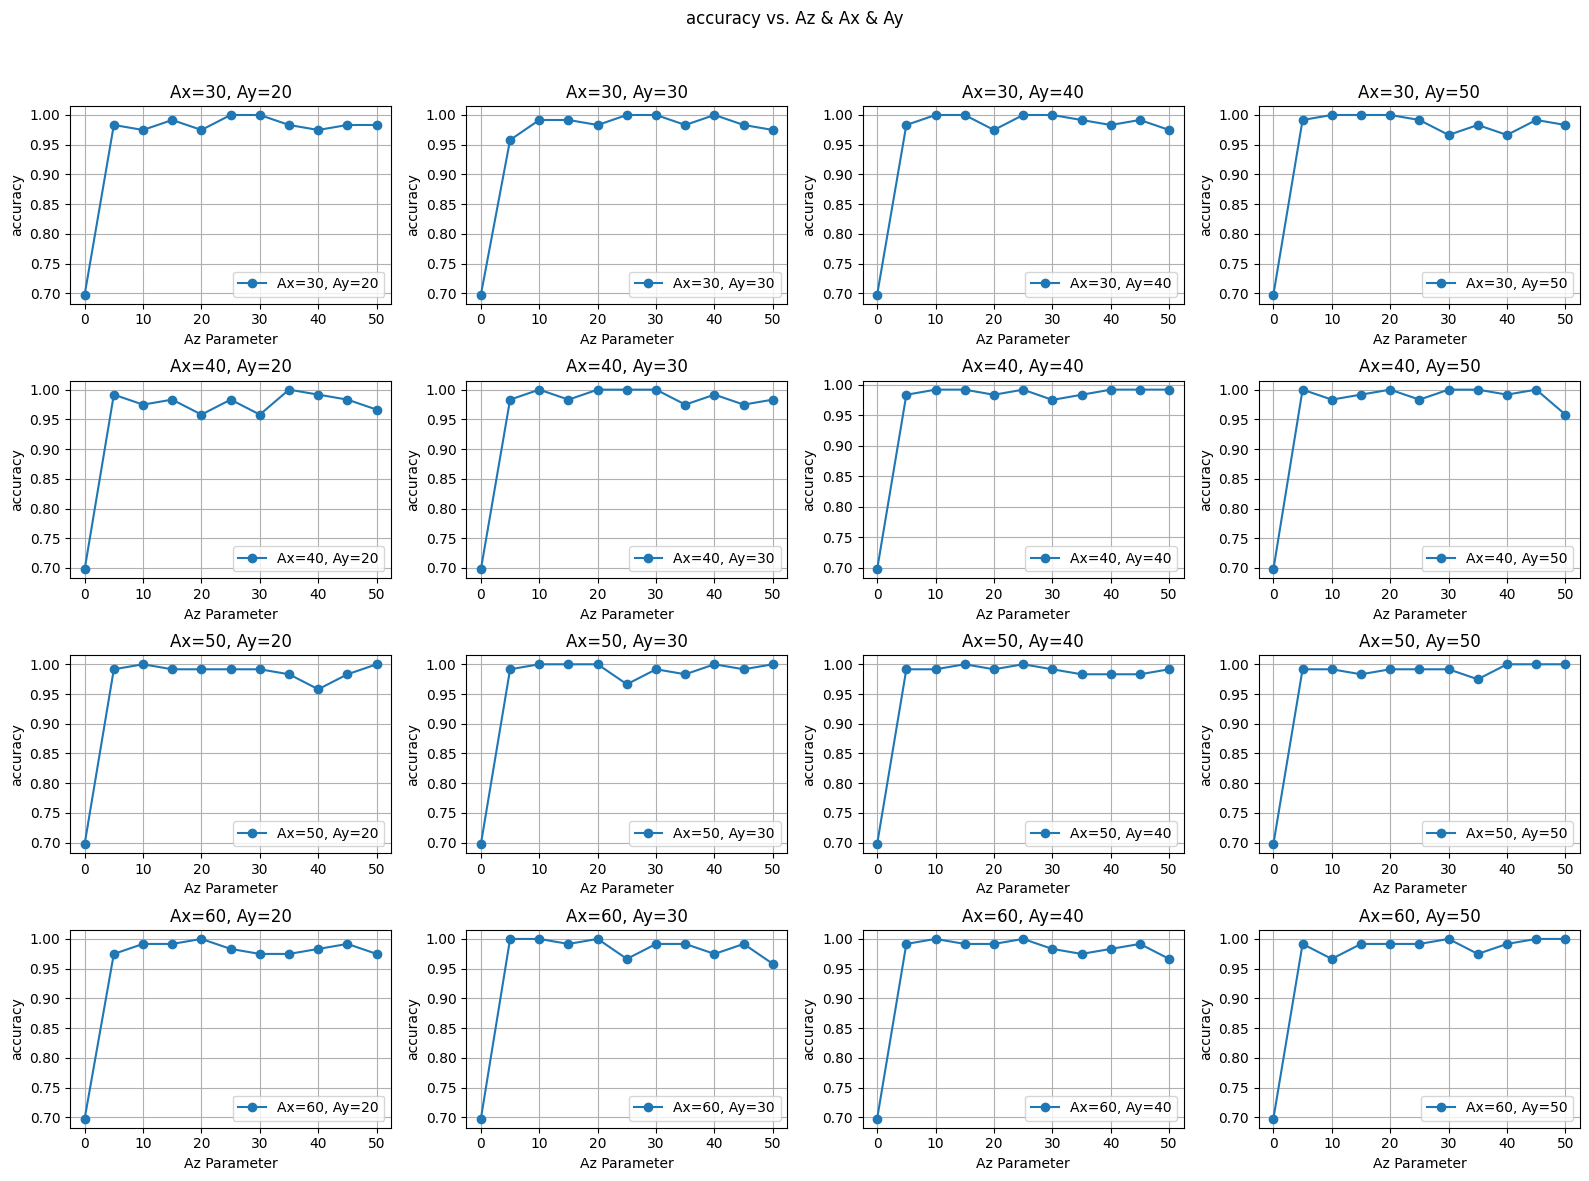

In [41]:
params = {
    "Az_VALUES": np.linspace(0, Config.Az_DEFAULT_VALUE, Config.BINS_SIZE + 1),
    "Ax_VALUES": [30, 40, 50, 60],
    "Ay_VALUES": [20, 30, 40, 50],
    "metric": "accuracy"
}

# run_and_plot_experiment(params)

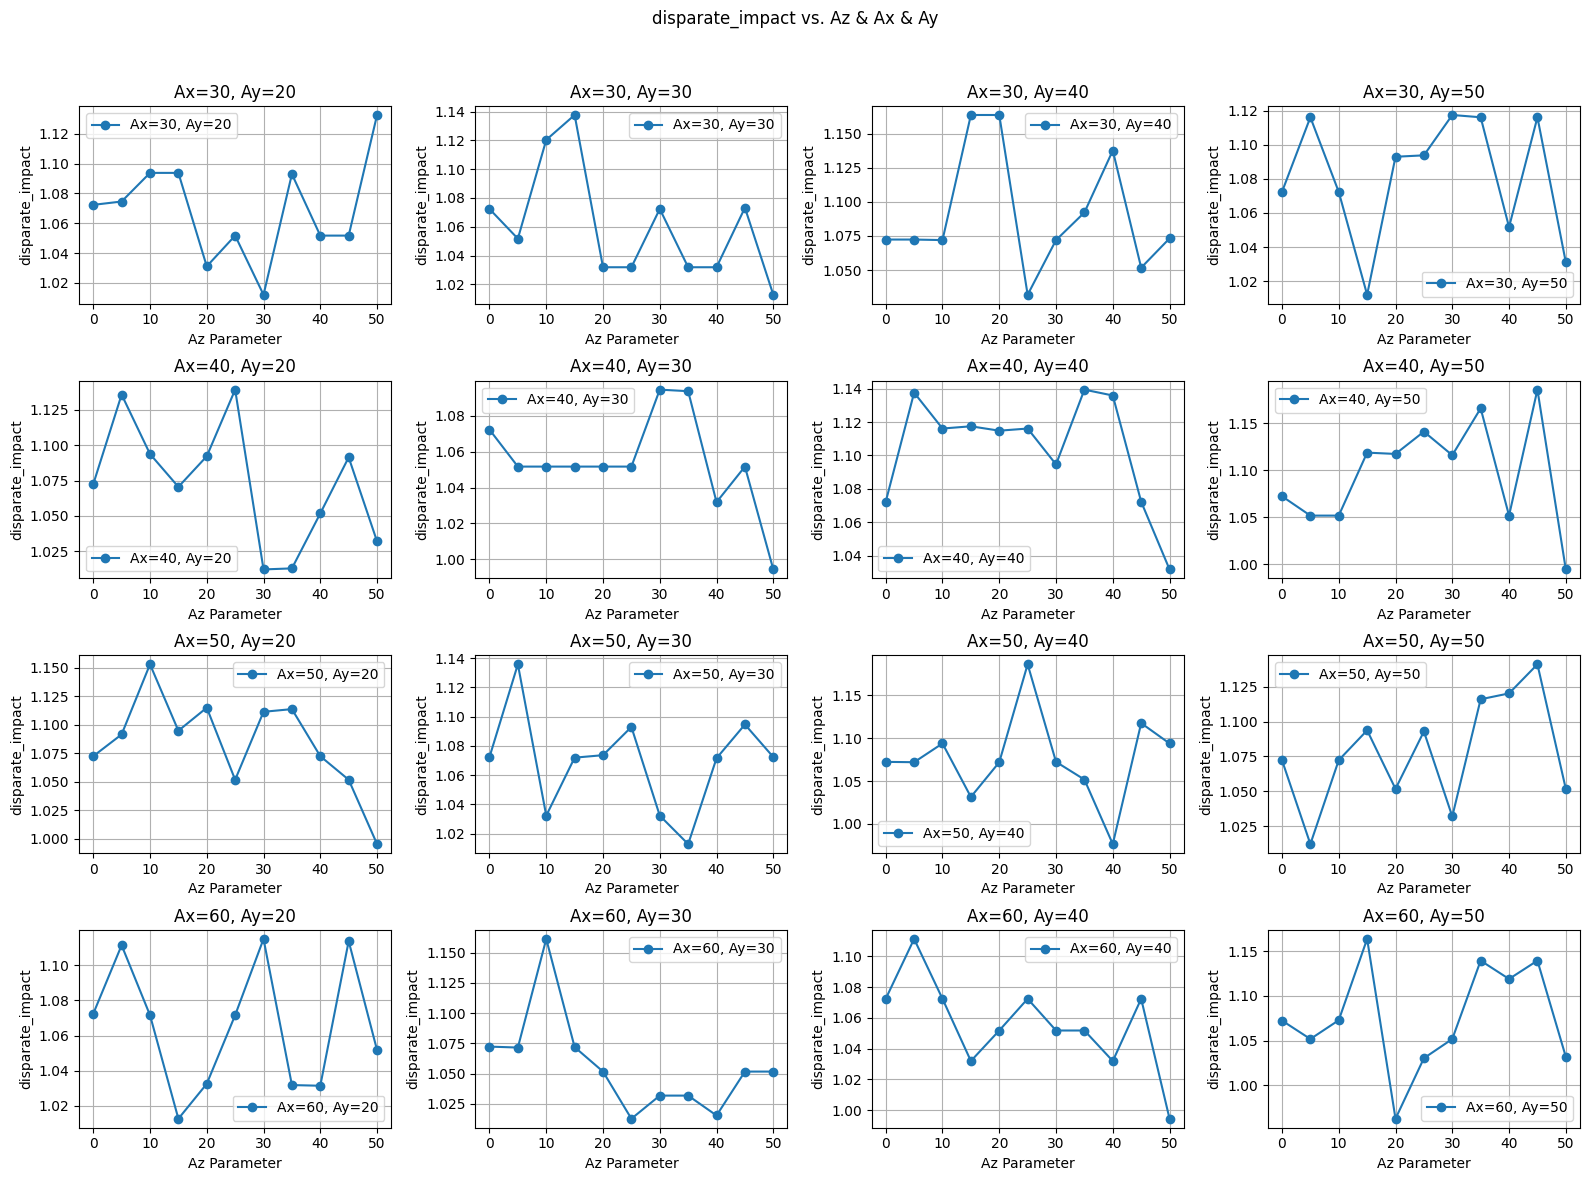

In [42]:
params = {
    "Az_VALUES": np.linspace(0, Config.Az_DEFAULT_VALUE, Config.BINS_SIZE + 1),
    "Ax_VALUES": [30, 40, 50, 60],
    "Ay_VALUES": [20, 30, 40, 50],
    "metric": "disparate_impact",
    "unprivileged_groups": unprivileged_groups,
    "privileged_groups": privileged_groups
}

# run_and_plot_experiment(params)

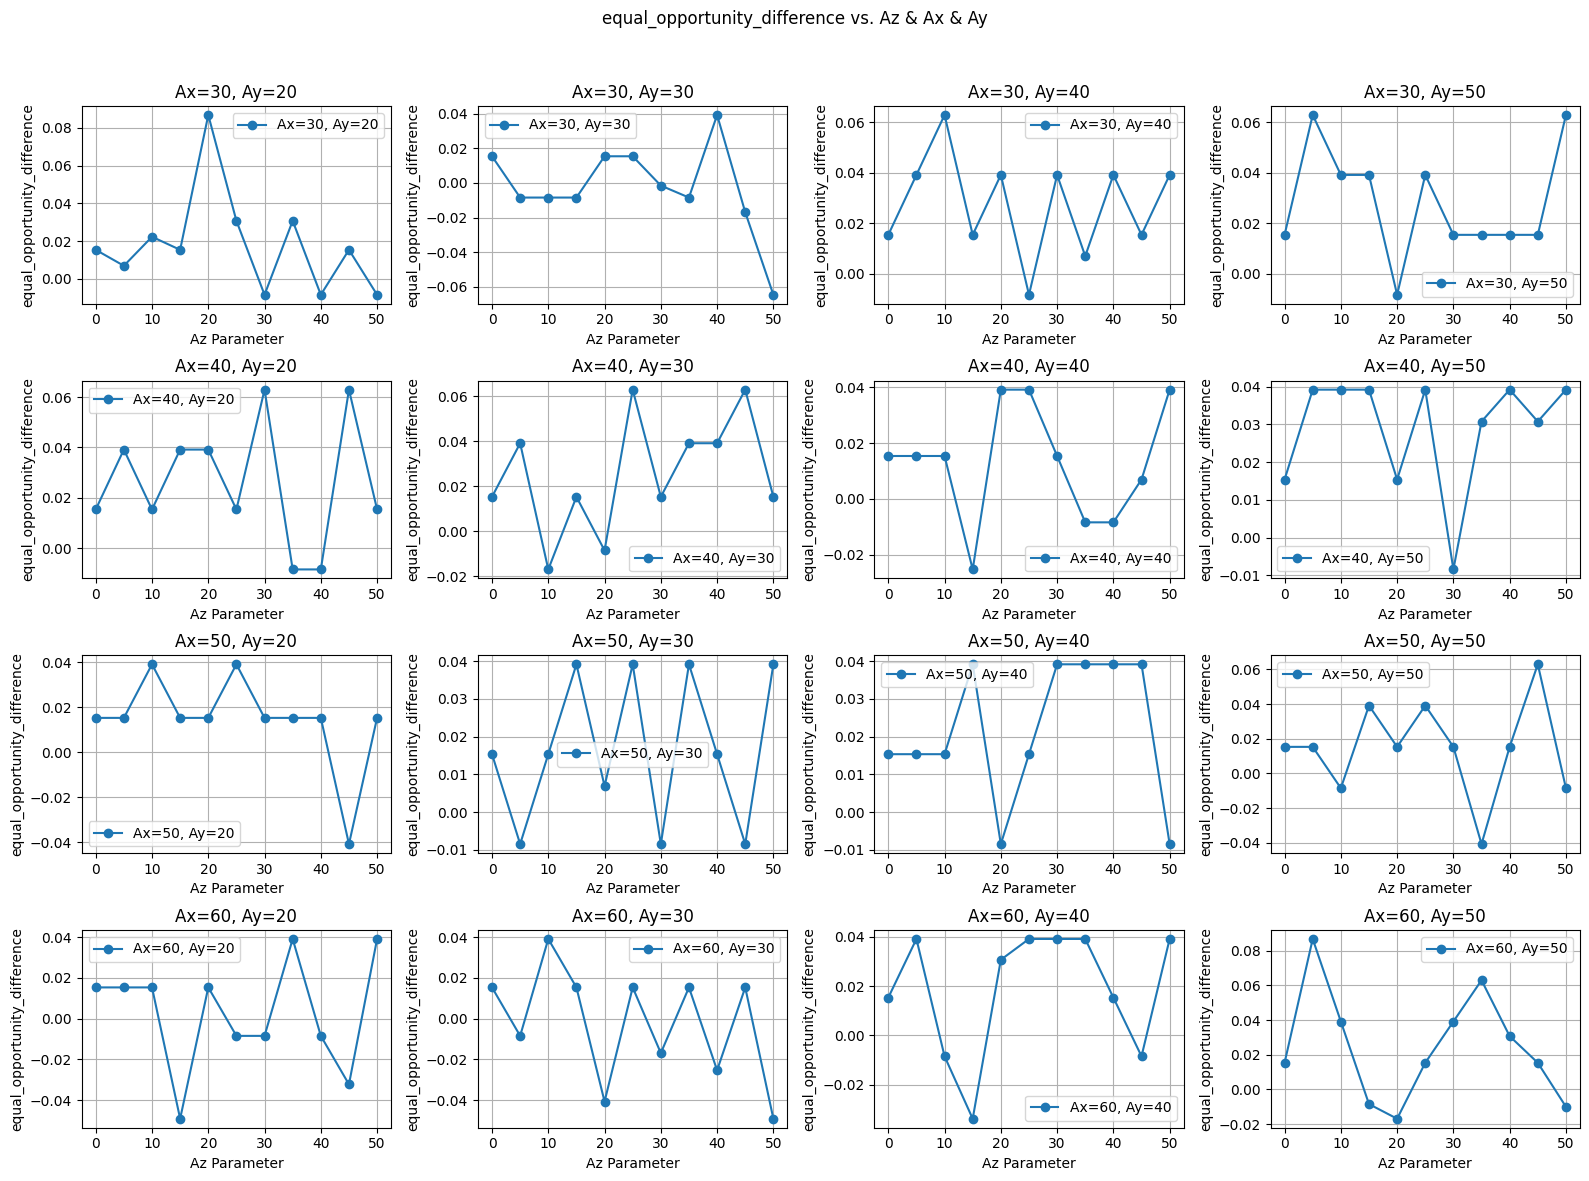

In [43]:
params = {
    "Az_VALUES": np.linspace(0, Config.Az_DEFAULT_VALUE, Config.BINS_SIZE + 1),
    "Ax_VALUES": [30, 40, 50, 60],
    "Ay_VALUES": [20, 30, 40, 50],
    "metric": "equal_opportunity_difference",
    "unprivileged_groups": unprivileged_groups,
    "privileged_groups": privileged_groups
}

# run_and_plot_experiment(params)

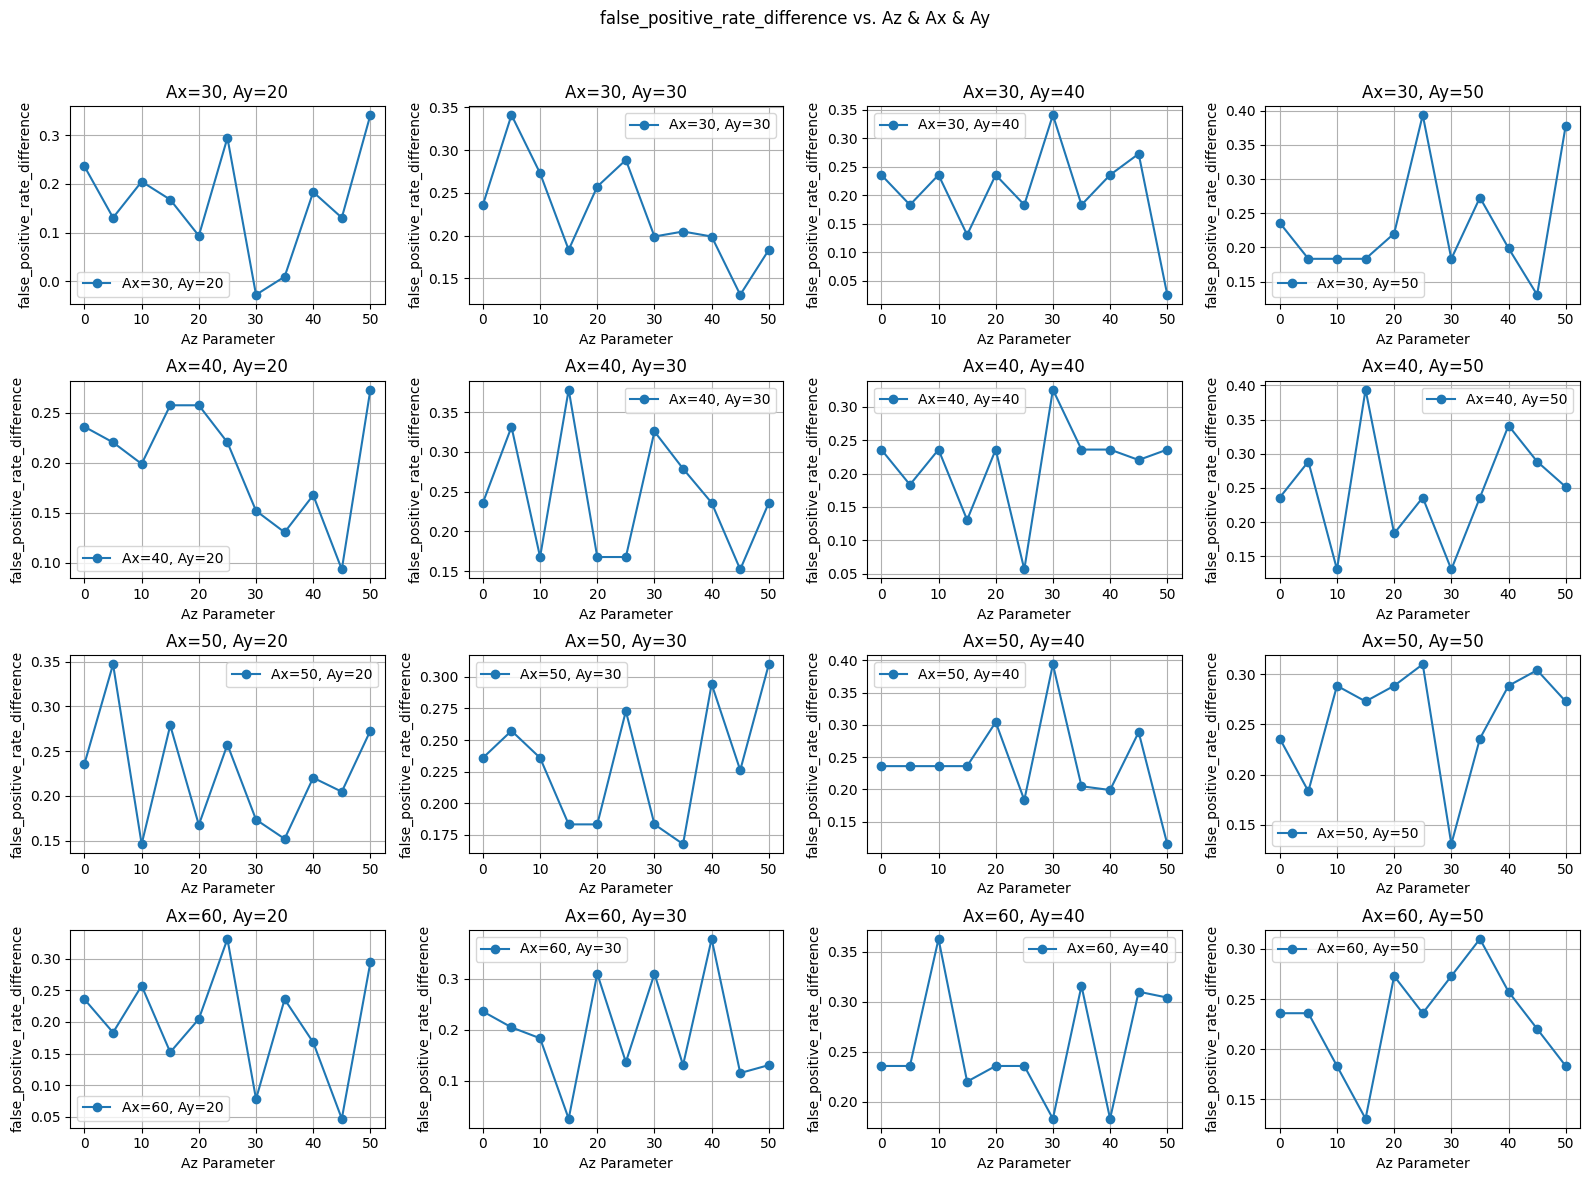

In [44]:
params = {
    "Az_VALUES": np.linspace(0, Config.Az_DEFAULT_VALUE, Config.BINS_SIZE + 1),
    "Ax_VALUES": [30, 40, 50, 60],
    "Ay_VALUES": [20, 30, 40, 50],
    "metric": "false_positive_rate_difference",
    "unprivileged_groups": unprivileged_groups,
    "privileged_groups": privileged_groups
}

# run_and_plot_experiment(params)

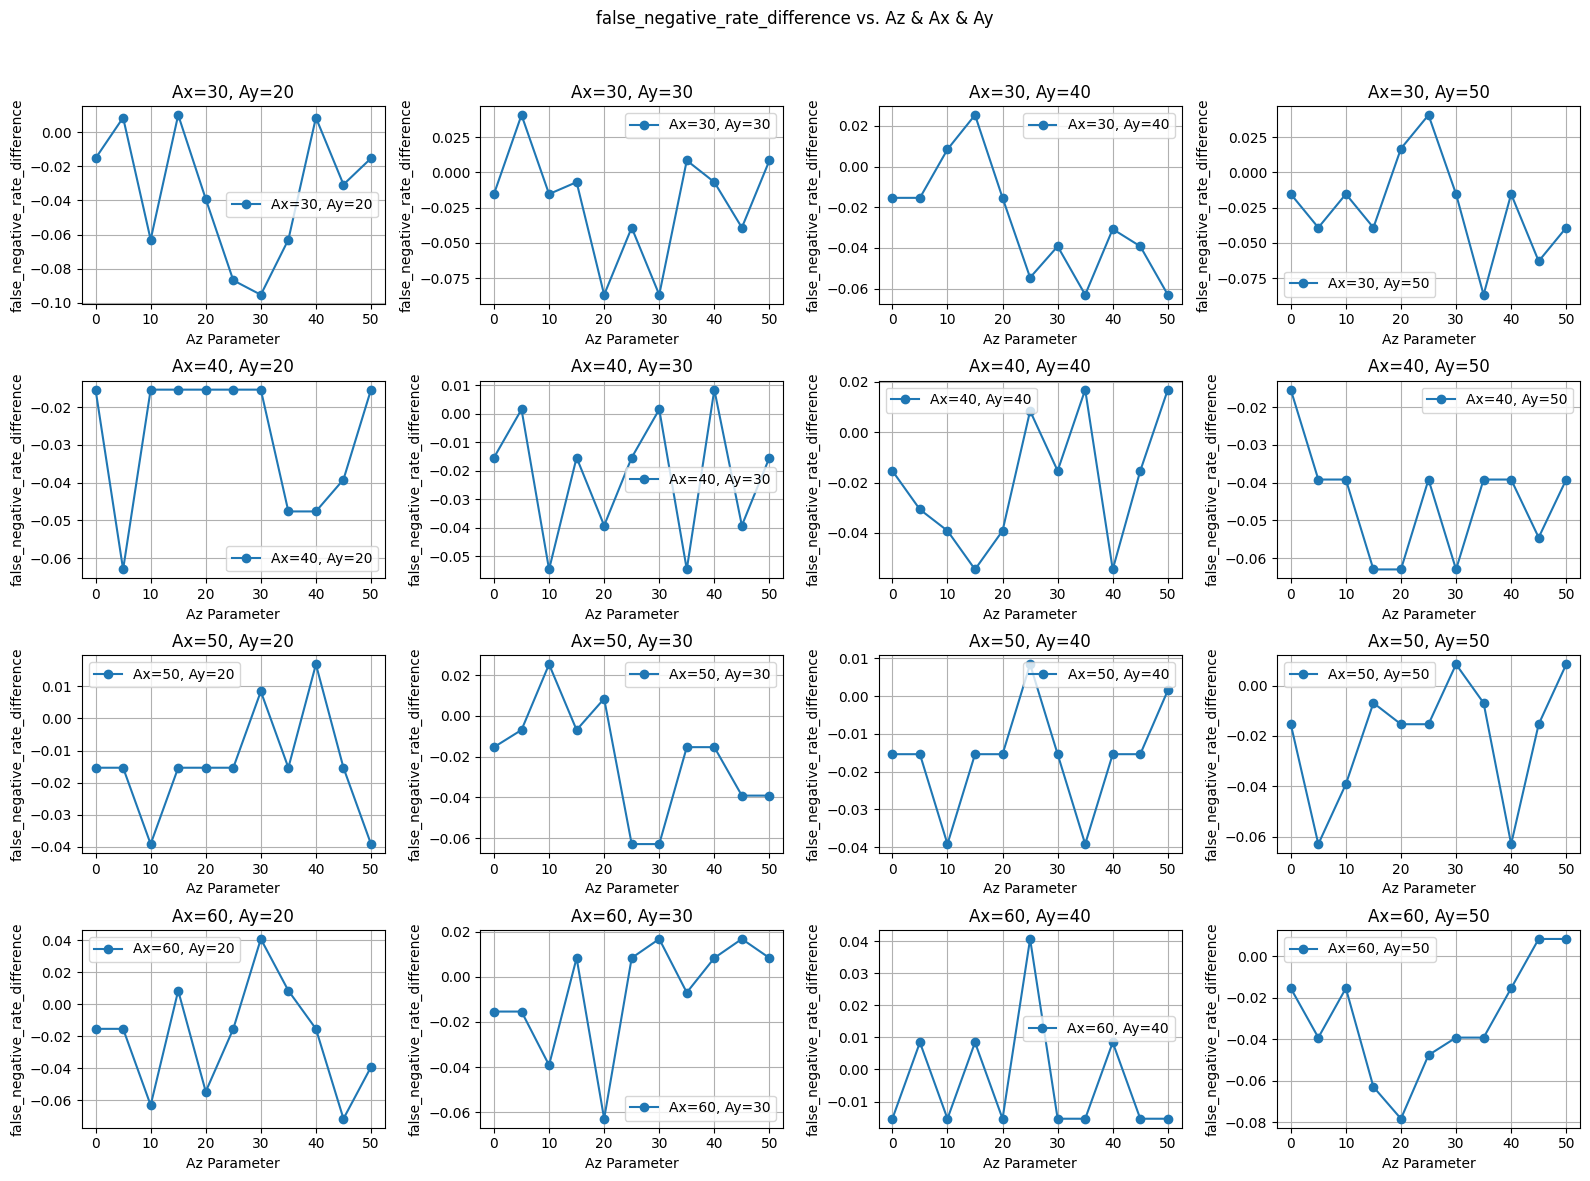

In [45]:
params = {
    "Az_VALUES": np.linspace(0, Config.Az_DEFAULT_VALUE, Config.BINS_SIZE + 1),
    "Ax_VALUES": [30, 40, 50, 60],
    "Ay_VALUES": [20, 30, 40, 50],
    "metric": "false_negative_rate_difference",
    "unprivileged_groups": unprivileged_groups,
    "privileged_groups": privileged_groups
}

# run_and_plot_experiment(params)

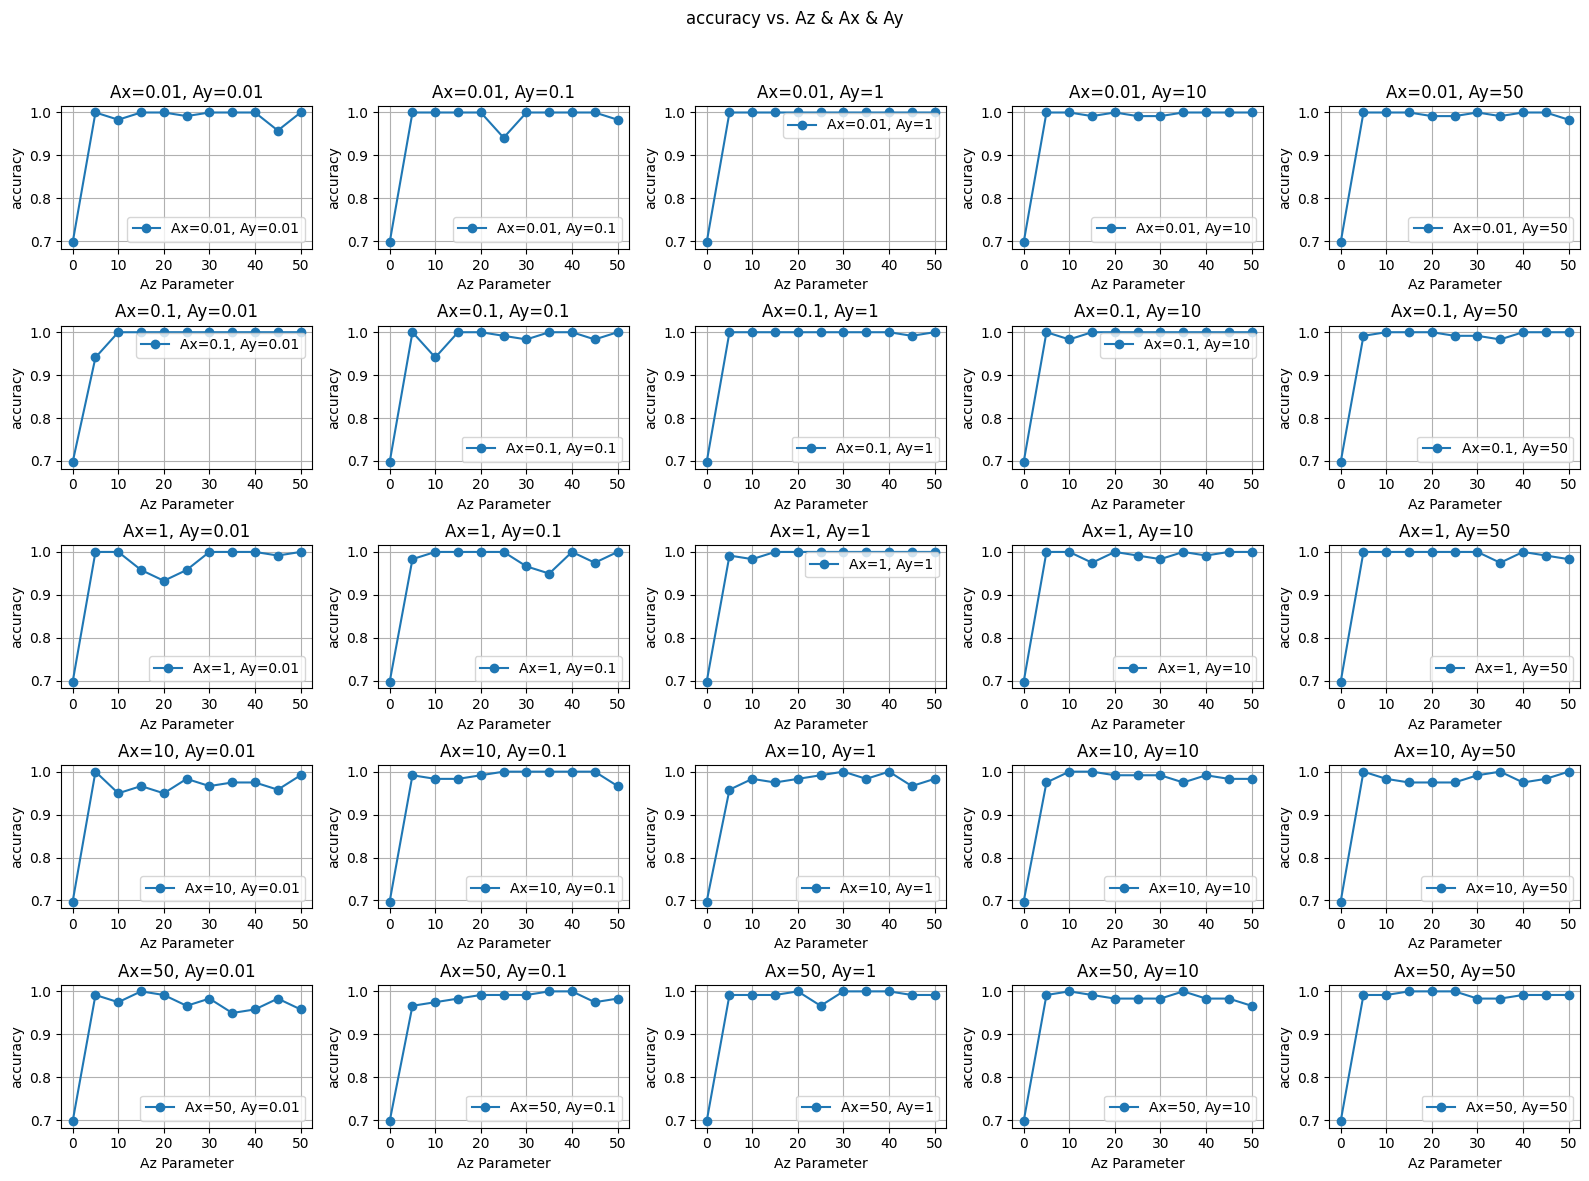

In [46]:
params = {
    "Az_VALUES": np.linspace(0, Config.Az_DEFAULT_VALUE, Config.BINS_SIZE + 1),
    "Ax_VALUES": [0.01, 0.1, 1, 10, 50],
    "Ay_VALUES": [0.01, 0.1, 1, 10, 50],
    "metric": "accuracy"
}

# run_and_plot_experiment(params)



# run experiment Ax=10, Ay=0.01, Az=Az (with that)

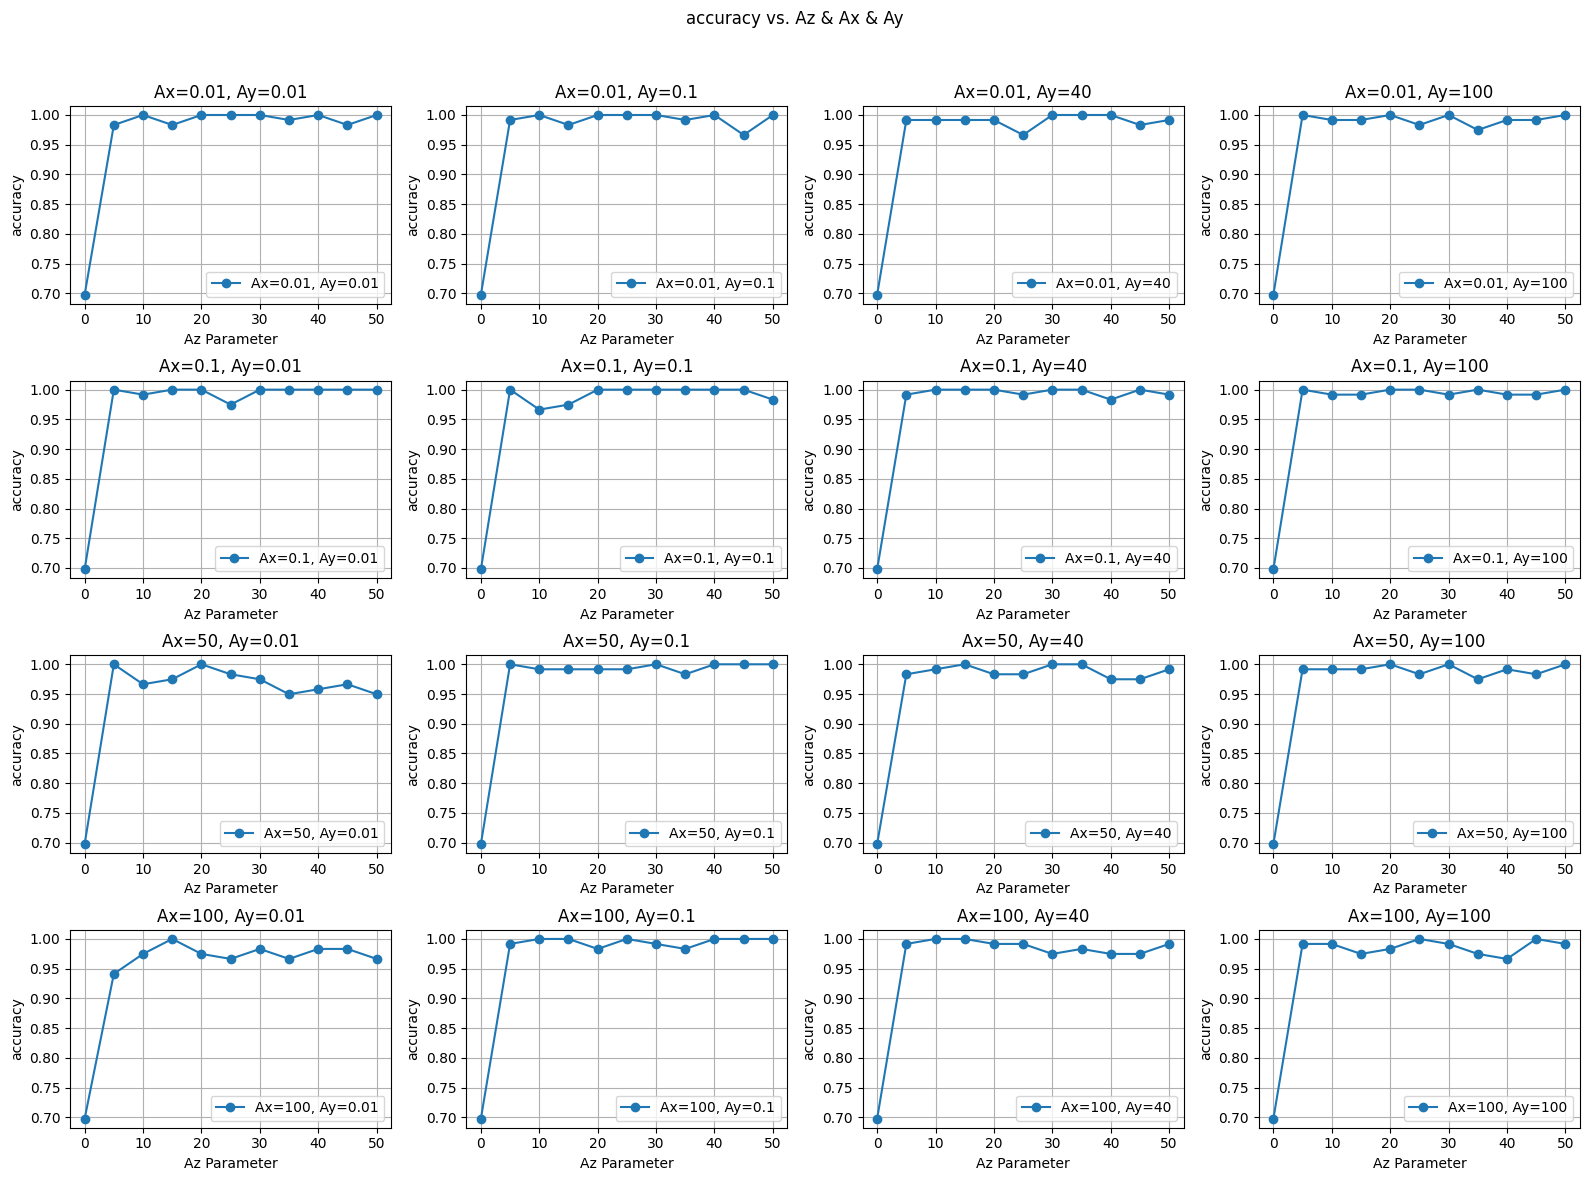

In [47]:
params = {
    "Az_VALUES": np.linspace(0, Config.Az_DEFAULT_VALUE, Config.BINS_SIZE + 1),
    "Ax_VALUES": [0.01, 0.1, 50, 100],
    "Ay_VALUES": [0.01, 0.1, 40, 100],
    "metric": "accuracy",
    "unprivileged_groups": unprivileged_groups,
    "privileged_groups": privileged_groups
}

# run_and_plot_experiment(params)

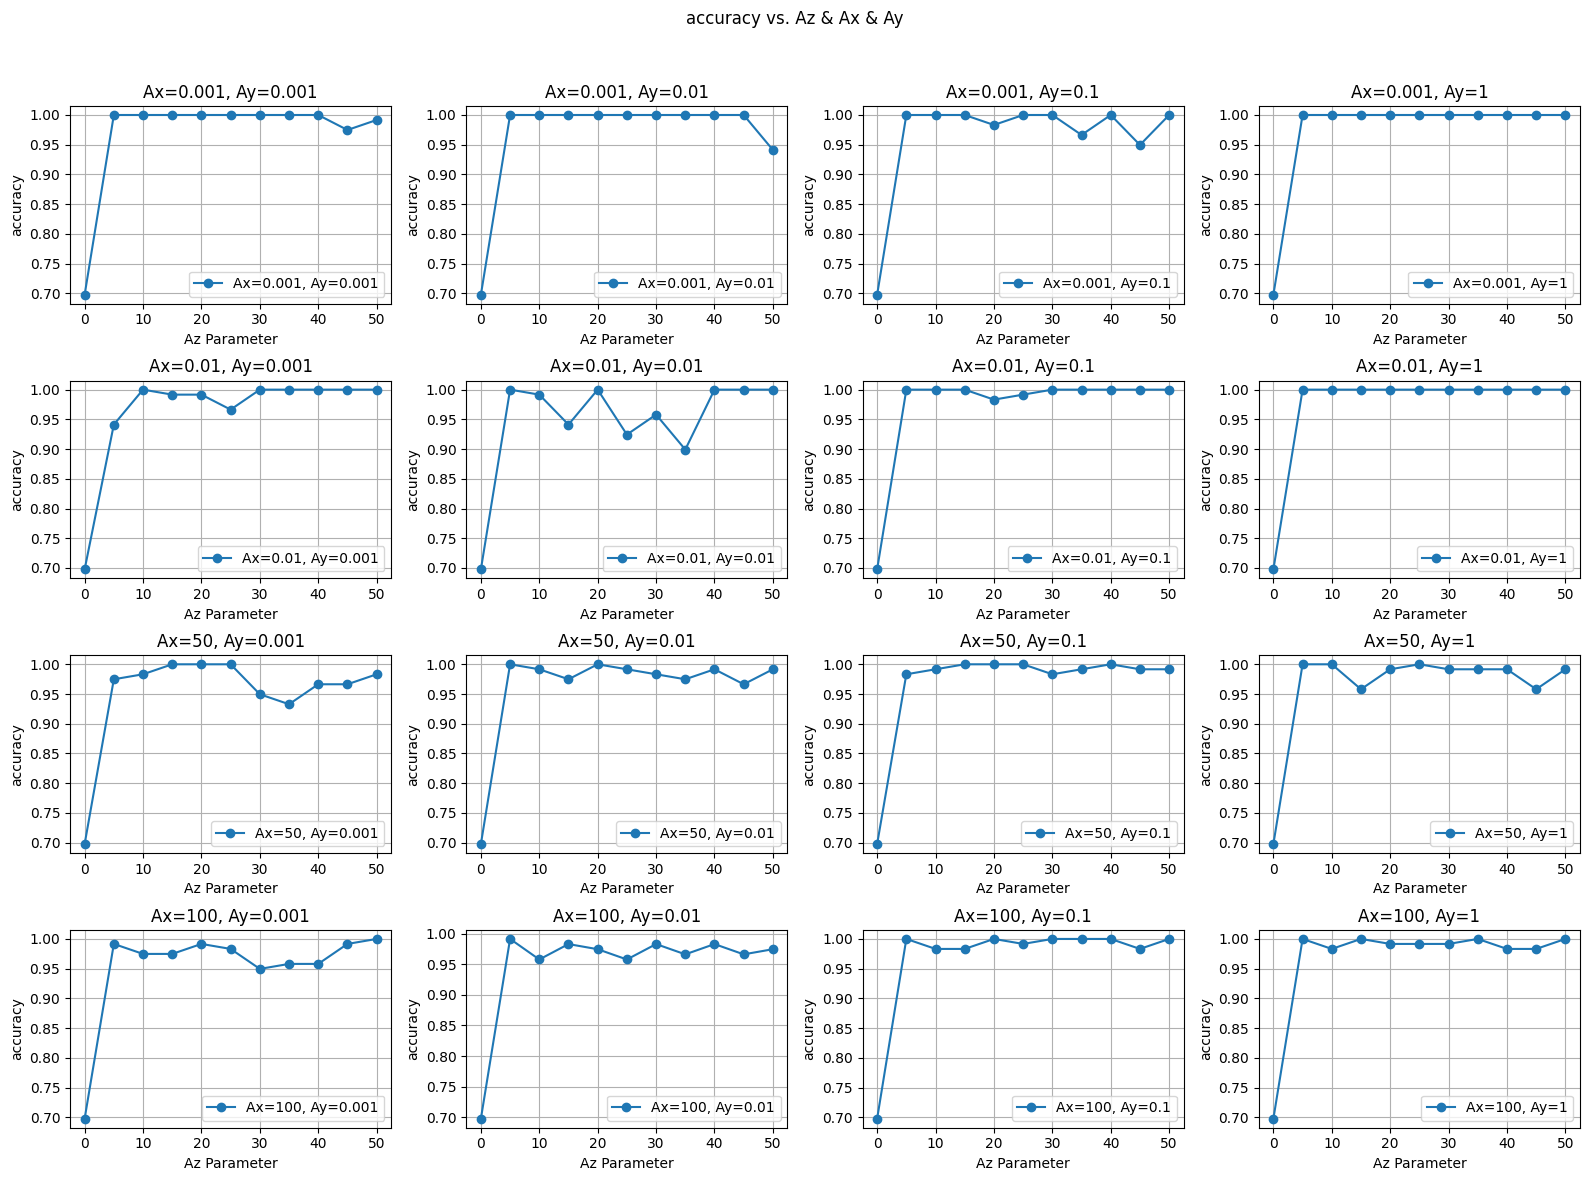

In [48]:
params = {
    "Az_VALUES": np.linspace(0, Config.Az_DEFAULT_VALUE, Config.BINS_SIZE + 1),
    "Ax_VALUES": [0.001, 0.01, 50, 100],
    "Ay_VALUES": [0.001, 0.01, 0.1, 1],
    "metric": "accuracy",
    "unprivileged_groups": unprivileged_groups,
    "privileged_groups": privileged_groups
}

# run_and_plot_experiment(params)

/Users/tarasbohdan/Desktop/Experiments-AAAI-24/virny_venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tarasbohdan/Desktop/Experiments-AAAI-24/virny_venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tarasbohdan/Desktop/Experiments-AAAI-24/virny_venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

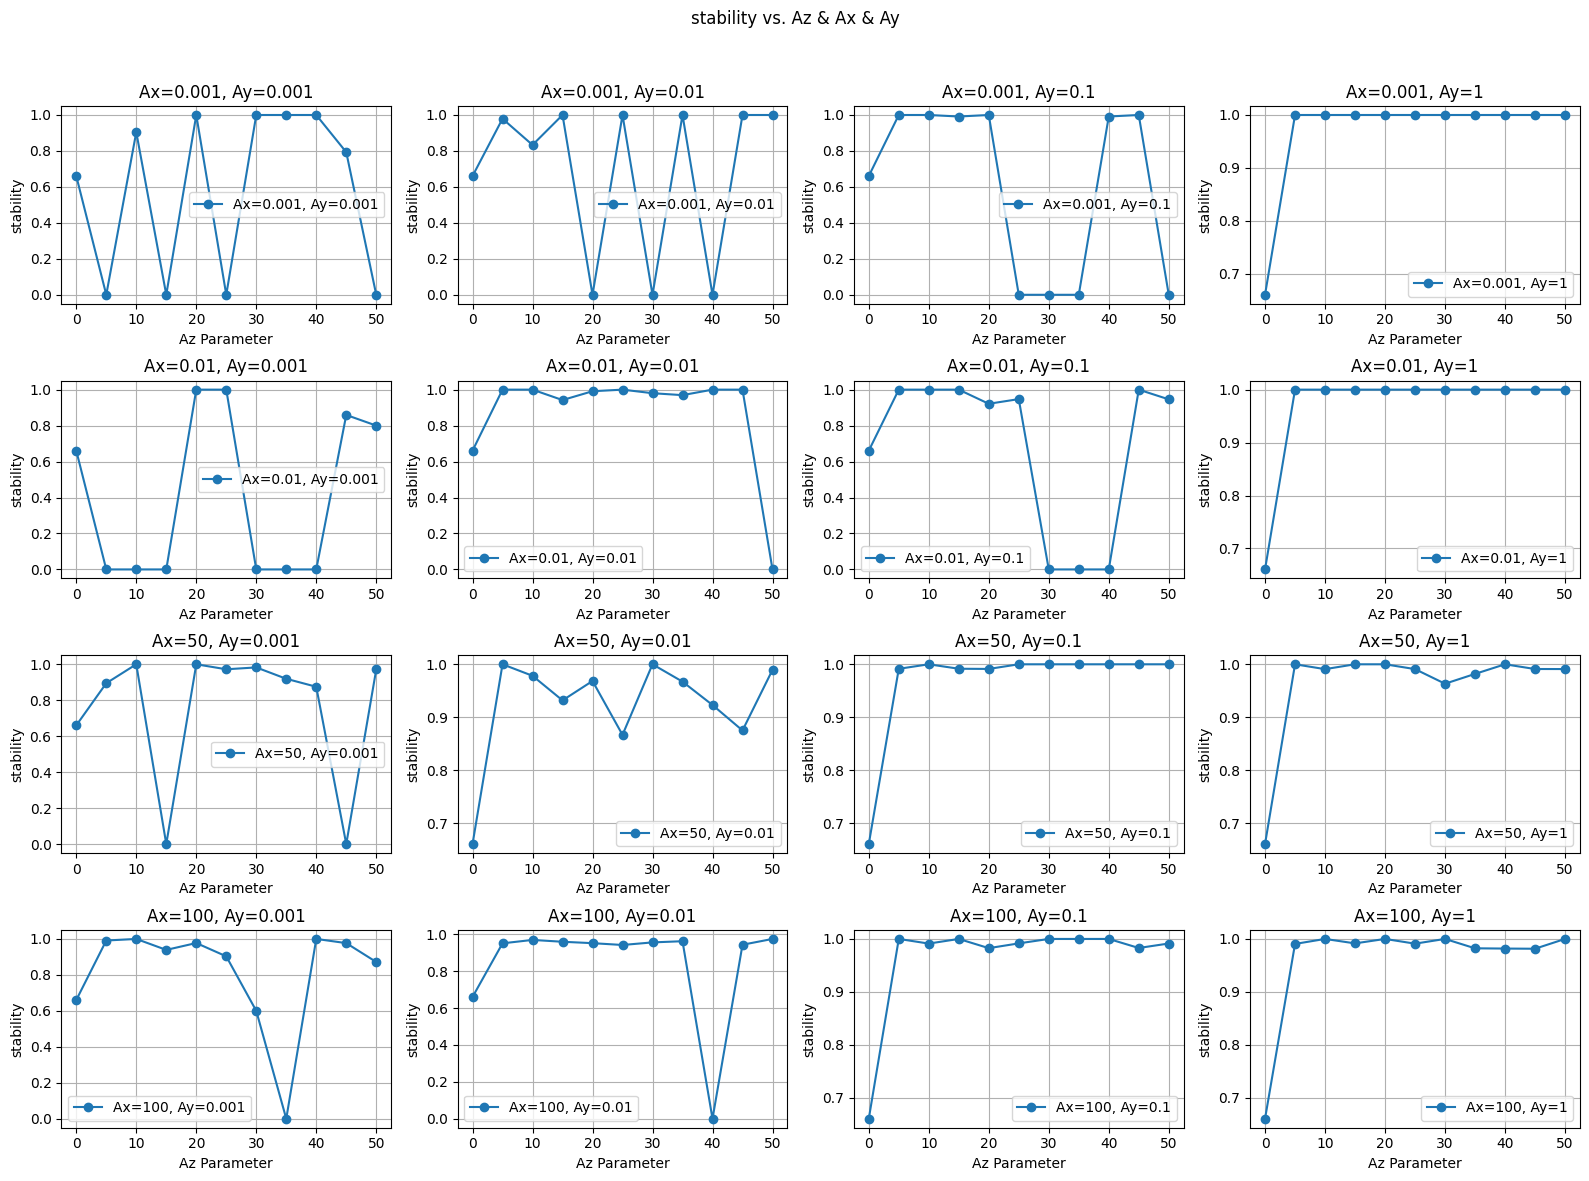

In [49]:
params = {
    "Az_VALUES": np.linspace(0, Config.Az_DEFAULT_VALUE, Config.BINS_SIZE + 1),
    "Ax_VALUES": [0.001, 0.01, 50, 100],
    "Ay_VALUES": [0.001, 0.01, 0.1, 1],
    "metric": "stability",
    "unprivileged_groups": unprivileged_groups,
    "privileged_groups": privileged_groups
}

# run_and_plot_experiment(params)

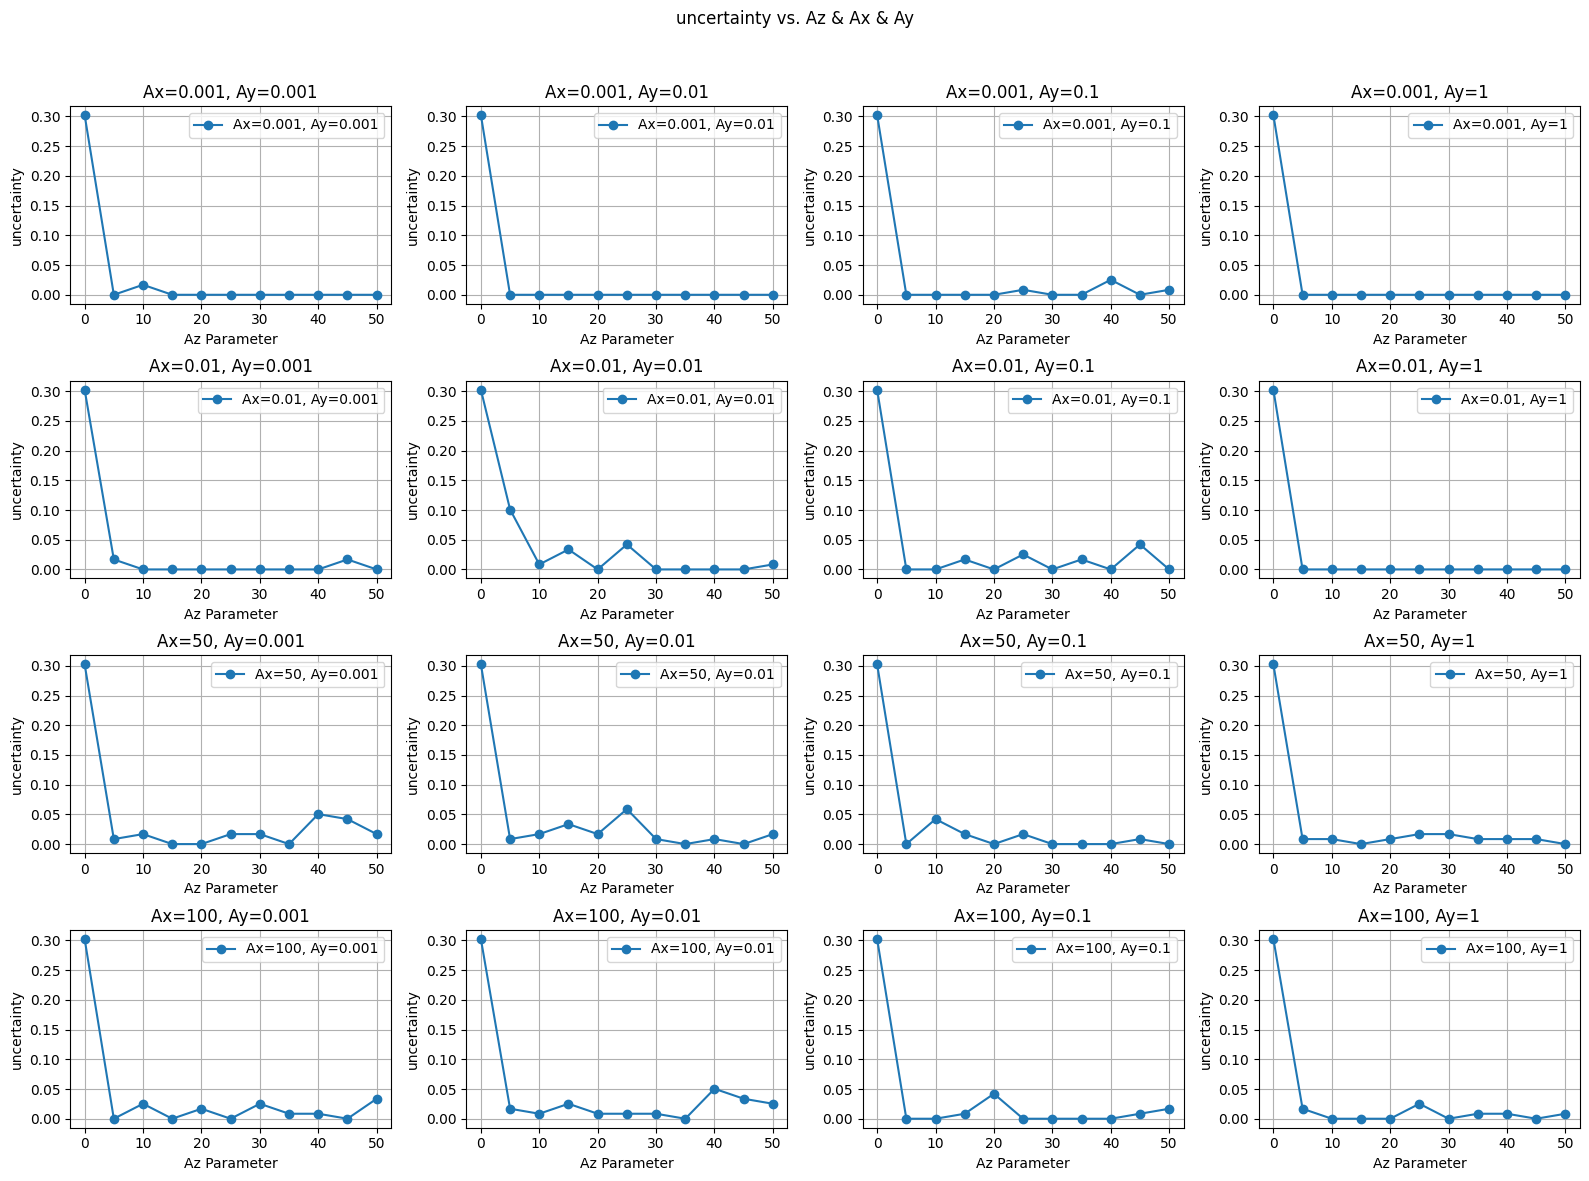

In [50]:
params = {
    "Az_VALUES": np.linspace(0, Config.Az_DEFAULT_VALUE, Config.BINS_SIZE + 1),
    "Ax_VALUES": [0.001, 0.01, 50, 100],
    "Ay_VALUES": [0.001, 0.01, 0.1, 1],
    "metric": "uncertainty",
    "unprivileged_groups": unprivileged_groups,
    "privileged_groups": privileged_groups
}

# run_and_plot_experiment(params)

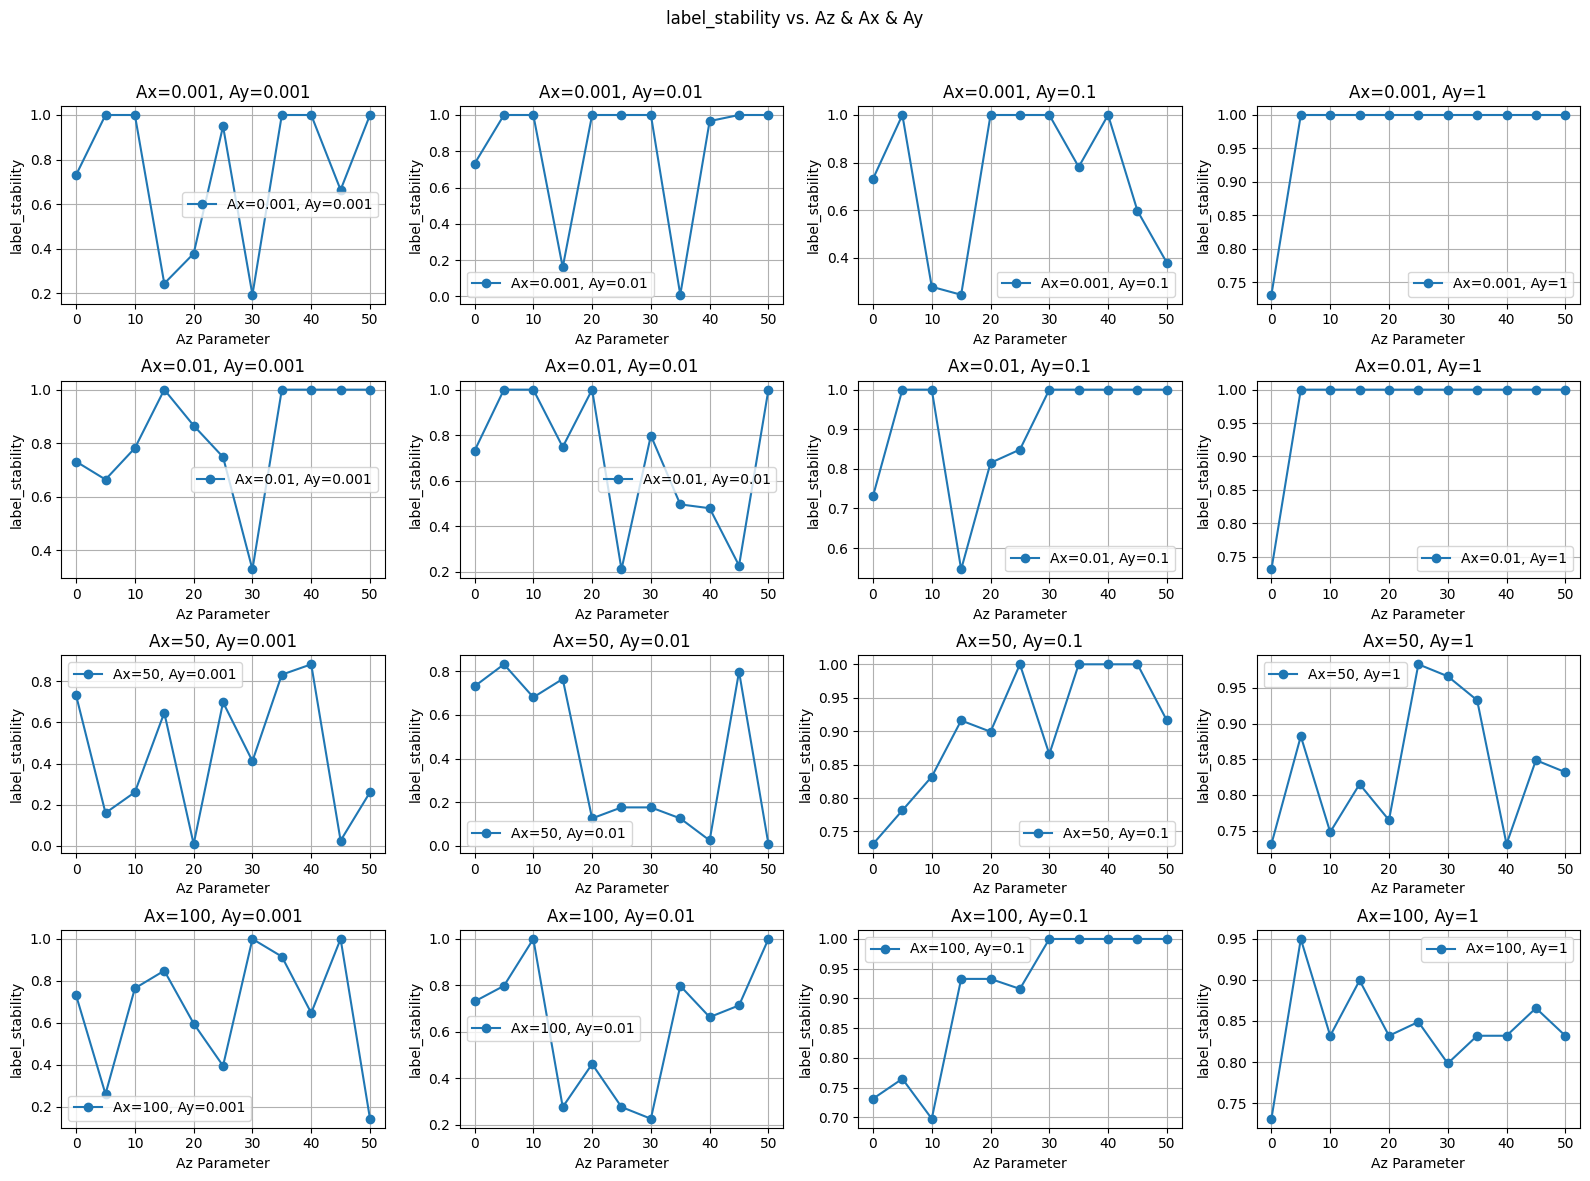

In [40]:
params = {
    "Az_VALUES": np.linspace(0, Config.Az_DEFAULT_VALUE, Config.BINS_SIZE + 1),
    "Ax_VALUES": [0.001, 0.01, 50, 100],
    "Ay_VALUES": [0.001, 0.01, 0.1, 1],
    "metric": "label_stability",
    "unprivileged_groups": unprivileged_groups,
    "privileged_groups": privileged_groups
}

# run_and_plot_experiment(params)

## test

In [51]:
import pandas as pd

def test_between_group():
    data = np.array([[0, 0, 1],
                     [0, 1, 0],
                     [1, 1, 0],
                     [1, 1, 1],
                     [1, 0, 0],
                     [1, 0, 0]])
    pred = data.copy()
    pred[[0, 3], -1] = 0
    pred[[4, 5], -1] = 1
    print(pred)
    print(data)
    df = pd.DataFrame(data, columns=['feat', 'feat2', 'label'])
    df2 = pd.DataFrame(pred, columns=['feat', 'feat2', 'label'])
    bld = BinaryLabelDataset(df=df, label_names=['label'],
        protected_attribute_names=['feat', 'feat2'])
    bld2 = BinaryLabelDataset(df=df2, label_names=['label'],
        protected_attribute_names=['feat', 'feat2'])
    cm = ClassificationMetric(bld, bld2, unprivileged_groups=[{'feat': 0}],
        privileged_groups=[{'feat': 1}])

    b = np.array([0.5, 0.5, 1.25, 1.25, 1.25, 1.25])
    assert cm.between_group_generalized_entropy_index() == 1/12*np.sum(b**2 - 1)

In [52]:
test_between_group()

[[0 0 0]
 [0 1 0]
 [1 1 0]
 [1 1 0]
 [1 0 1]
 [1 0 1]]
[[0 0 1]
 [0 1 0]
 [1 1 0]
 [1 1 1]
 [1 0 0]
 [1 0 0]]
